In [ ]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3f32d837857b76714ba88069096762a448066dababbf6d038055c4cf63857810
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split as TTS

import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.metrics import mean_squared_error as MAE
from sklearn.model_selection import KFold
import japanize_matplotlib

path_start = Path("/content/drive/MyDrive/Nishika/Mansion_2023_spring")

Mounted at /content/drive


In [ ]:
train = pd.read_csv(path_start/"input/df_train.csv", index_col=0)
test = pd.read_csv(path_start/"input/test.csv", index_col=0)
sample = pd.read_csv(path_start/"input/sample_submission.csv")

df_ConCat = pd.concat([train, test])
print(df_ConCat.shape)

(784713, 28)


## 特徴量の削除

In [ ]:
Fvalue = lambda x: df_ConCat.drop(x, axis=1)
List_del = ["取引時点", "市区町村名", "間取り", "種類",
            "前面道路：方位", "前面道路：種類",	"前面道路：幅員（ｍ）", "地域", "土地の形状",
            "間口", "建物の構造", "延床面積（㎡）", "用途",
            "取引の事情等", "最寄駅：名称"]

for c in List_del:
  df_ConCat = df_ConCat.drop(c, axis=1)
display(df_ConCat.shape)
df_ConCat.head()

(784713, 13)

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,建築年,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引価格（総額）_log
0,8067540,8217,茨城県,野々井,13,70,1996.0,NaN,第１種住居地域,60.0,200.0,未改装,6.977724
1,8027265,8219,茨城県,ひたち野東,8,70,1998.0,住宅,第２種中高層住居専用地域,60.0,200.0,未改装,7.255273
2,8061526,8220,茨城県,苅間,4,105,2009.0,NaN,商業地域,80.0,400.0,未改装,7.556303
3,8086147,8220,茨城県,並木,75,100,2007.0,NaN,第１種中高層住居専用地域,60.0,200.0,未改装,7.380211
4,8049498,8224,茨城県,ひがし野,8,95,2009.0,住宅,近隣商業地域,80.0,200.0,未改装,7.518514


## 標準化

In [ ]:
List_std = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
scaler = StandardScaler()
scaler.fit(df_ConCat[List_std])
df_ConCat[List_std] = scaler.transform(df_ConCat[List_std])
df_ConCat.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,建築年,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引価格（総額）_log
0,8067540,8217,茨城県,野々井,0.144049,0.431679,1996.0,NaN,第１種住居地域,-0.741730,-0.695601,未改装,6.977724
1,8027265,8219,茨城県,ひたち野東,-0.266625,0.431679,1998.0,住宅,第２種中高層住居専用地域,-0.741730,-0.695601,未改装,7.255273
2,8061526,8220,茨城県,苅間,-0.595164,1.726269,2009.0,NaN,商業地域,1.177623,0.650409,未改装,7.556303
3,8086147,8220,茨城県,並木,5.236408,1.541328,2007.0,NaN,第１種中高層住居専用地域,-0.741730,-0.695601,未改装,7.380211
4,8049498,8224,茨城県,ひがし野,-0.266625,1.356387,2009.0,住宅,近隣商業地域,1.177623,-0.695601,未改装,7.518514


## 特徴量120個に絞る

In [ ]:
for i in glob(str(path_start/"TargetEncoding/*.csv")):
  df_ConCat = pd.merge(df_ConCat, pd.read_csv(i), on="ID", how="left")

In [ ]:
for i in glob(str(path_start/"LoE/*.csv")):
  df_ConCat = pd.merge(df_ConCat, pd.read_csv(i), on="ID", how="left")
df_ConCat.shape

(784713, 280)

In [ ]:
list_handred = pd.read_csv(path_start/"my_list_100.csv", header=None).values.tolist()
flattened = [x for row in list_handred for x in row]
display(len(flattened))
display(flattened)

100

['建築年',
 '地区名',
 '面積（㎡）',
 '市区町村名_LoEＲ５価格',
 '都道府県名',
 '最寄駅：距離（分）',
 '最寄駅：名称_LoEＲ５価格',
 '最寄駅：名称_LoE駅別乗降客数_2022',
 '市区町村名_LoE都道府県別人口',
 '取引時点_LoE取引時期_年',
 '間取り_TE取引時期_四半期',
 '改装_LoE建築年',
 '取引時点_TE取引時期_年四半期',
 '取引時点_LoE建築年',
 '間取り_LoE面積（㎡）',
 '市区町村コード',
 '取引時点_LoE取引時期_年四半期',
 '改装',
 '最寄駅：名称_LoE都道府県別人口',
 '市区町村名_LoE駅別乗降客数_2022',
 'ID',
 '地区名_TE最寄駅：距離（分）',
 '都市計画',
 '地区名_LoE都道府県別人口',
 '取引の事情等_TE取引時期_四半期',
 '改装_LoE取引-建築',
 '今後の利用目的',
 '取引の事情等_TE建築年',
 '取引時点_LoE取引-建築',
 '取引時点_TE建築年',
 '取引時点_TE面積（㎡）',
 '取引の事情等_TE容積率（％）',
 '市区町村名_TE建ぺい率（％）',
 '地区名_TE建築年',
 '改装_LoE取引時期_四半期',
 '今後の利用目的_LoE取引時期_四半期',
 '市区町村名_TE容積率（％）',
 '都道府県名_LoE駅別乗降客数_2022',
 '地区名_LoE最寄駅：距離（分）',
 '最寄駅：名称_TE建ぺい率（％）',
 '今後の利用目的_LoE建築年',
 '都道府県名_TE面積（㎡）',
 '最寄駅：名称_TE容積率（％）',
 '市区町村名_LoE容積率（％）',
 '市区町村コード_LoE取引-建築',
 '都道府県名_LoE都道府県別人口',
 '取引時点_TE建ぺい率（％）',
 '取引時点_TE取引-建築',
 '容積率（％）',
 '建物の構造_LoE建築年',
 '市区町村コード_LoE建築年',
 '取引時点_TE最寄駅：距離（分）',
 '都道府県名_LoE建築年',
 '市区町村名_TE取引時期_年',
 '市区町村名_LoE取引時期_四半期',
 '取引の事情等_TE取引時期_年',
 '市区町村名_TE取引時期_四

In [ ]:
df_ConCat2 = pd.concat([df_ConCat[["取引価格（総額）_log"]], df_ConCat[flattened]], axis=1)
df_ConCat2 = df_ConCat2.drop("建築年", axis=1)
df_ConCat2.head()

,取引価格（総額）_log,地区名,面積（㎡）,市区町村名_LoEＲ５価格,都道府県名,最寄駅：距離（分）,最寄駅：名称_LoEＲ５価格,最寄駅：名称_LoE駅別乗降客数_2022,市区町村名_LoE都道府県別人口,取引時点_LoE取引時期_年,...,間取り_LoE取引時期_年,間取り_LoE駅別乗降客数_2022,取引時点_TE容積率（％）,最寄駅：名称_TE取引時期_年四半期,取引時点_LoE容積率（％）,最寄駅：名称_TE取引-建築,建物の構造_LoE取引時期_年四半期,都市計画_LoE面積（㎡）,都市計画_LoE建築年,用途_LoE取引-建築
0,6.977724,野々井,0.431679,1.696646,茨城県,0.144049,1.696646,7.301799e-17,2.158193,4.079735e-16,...,4.079735e-16,7.301799e-17,-0.102286,-0.096591,1.795081e-16,-0.073848,2.008574e-14,9.634318e-17,-9.351263e-15,4.357893e-17
1,7.255273,ひたち野東,0.431679,1.696646,茨城県,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,...,-8.019482e-01,-3.153441e-01,0.028981,0.046625,1.795081e-16,-0.802986,-7.901372e-01,9.634318e-17,-9.351263e-15,-3.183235e-01
2,7.556303,苅間,1.726269,1.696646,茨城県,-0.595164,1.696646,7.301799e-17,2.158193,4.079735e-16,...,-2.829774e-01,-3.498224e-01,-0.036798,0.463295,1.795081e-16,-1.037553,-2.651288e-01,9.634318e-17,-9.351263e-15,-1.765825e-01
3,7.380211,並木,1.541328,0.800354,茨城県,5.236408,1.696646,7.301799e-17,1.116102,4.079735e-16,...,4.079735e-16,7.301799e-17,-0.043977,-0.048201,1.795081e-16,-0.789819,-3.654620e-01,9.634318e-17,-9.351263e-15,-4.723217e-01
4,7.518514,ひがし野,1.356387,1.696646,茨城県,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,...,-1.586226e-01,-4.021073e-02,0.019880,0.420120,1.795081e-16,-0.924278,-3.719083e-01,9.634318e-17,-9.351263e-15,4.357893e-17


## 特徴量追加

In [ ]:
for i in glob(str(path_start/"feature_value/*.csv")):
  df_ConCat2 = pd.merge(df_ConCat2, pd.read_csv(i), on="ID", how="left")
display(df_ConCat2.shape)
df_ConCat2.head()

(784713, 195)

,取引価格（総額）_log,地区名,面積（㎡）,市区町村名_LoEＲ５価格,都道府県名,最寄駅：距離（分）,最寄駅：名称_LoEＲ５価格,最寄駅：名称_LoE駅別乗降客数_2022,市区町村名_LoE都道府県別人口,取引時点_LoE取引時期_年,...,取引時点_出現頻度,改装_出現頻度,取引の事情等_出現頻度,緯度,経度,pca_1,pca_2,pca_3,pca_4,pca_5
0,6.977724,野々井,0.431679,1.696646,茨城県,0.144049,1.696646,7.301799e-17,2.158193,4.079735e-16,...,8914,509046,765272,0.206981,0.758921,-1.044608e+07,-5403.721298,-565.632224,223.751718,128.508131
1,7.255273,ひたち野東,0.431679,1.696646,茨城県,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,...,11996,509046,765272,0.245632,0.789725,-1.048635e+07,5885.458879,1451.675270,-177.264155,233.016803
2,7.556303,苅間,1.726269,1.696646,茨城県,-0.595164,1.696646,7.301799e-17,2.158193,4.079735e-16,...,10934,509046,765272,0.305118,0.765607,-1.045209e+07,-4114.432501,-597.135897,336.992446,118.373051
3,7.380211,並木,1.541328,0.800354,茨城県,5.236408,1.696646,7.301799e-17,1.116102,4.079735e-16,...,13233,509046,765272,0.305118,0.765607,-1.042747e+07,5148.718008,1534.791716,241.136794,104.649805
4,7.518514,ひがし野,1.356387,1.696646,茨城県,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,...,12531,509046,765272,0.229294,0.728020,-1.046412e+07,5787.830754,151.758866,69.857509,171.090232


## ラベルエンコーディング

In [ ]:
List_Encode = []
for i, t in enumerate(df_ConCat2.dtypes):
  if t!="float64" and t!="int64":
    List_Encode.append(df_ConCat2.columns[i])

List_Encode

['地区名',
 '都道府県名',
 '改装',
 '都市計画',
 '今後の利用目的',
 '市名',
 '区名',
 '郡名',
 '町名',
 '間取り_+',
 '間取り_種類',
 '利用変異',
 '最寄駅：名称',
 '運営会社',
 '路線名']

In [ ]:
for c in List_Encode:
  le = LabelEncoder()
  le.fit(df_ConCat2[c])
  df_ConCat2[c] = le.transform(df_ConCat2[c])

In [ ]:
List_plus = ["用途_住宅", "用途_不明", "用途_店舗",	"用途_その他", "用途_事務所",
             "用途_駐車場", "用途_倉庫", "用途_作業場", "用途_工場", "建物の構造_ＲＣ",
             "建物の構造_鉄骨造", "建物の構造_ＳＲＣ", "建物の構造_不明", "建物の構造_木造", "建物の構造_軽量鉄骨造",
             "建物の構造_ブロック造", "間取り_数字", "利用変異", "取引の事情等_不明",	"取引の事情等_調停・競売等",
             "取引の事情等_瑕疵有りの可能性",	"取引の事情等_関係者間取引", "取引の事情等_その他事情有り", "取引の事情等_他の権利・負担付き",
             "利用一致_不明", "利用一致_住宅", "利用一致_その他", "利用一致_事務所", "利用一致_店舗",
             "市区町村コード", "ID"]
list_and = list(set(list(df_ConCat2.columns)).intersection(set(List_plus)))
display(type(list_and))
display(list_and)

list

['取引の事情等_不明',
 '用途_作業場',
 '用途_その他',
 '間取り_数字',
 '市区町村コード',
 '利用一致_不明',
 '利用一致_住宅',
 '建物の構造_ＳＲＣ',
 '利用変異',
 '取引の事情等_調停・競売等',
 '用途_住宅',
 '建物の構造_ＲＣ',
 '利用一致_事務所',
 '取引の事情等_関係者間取引',
 'ID',
 '建物の構造_鉄骨造',
 '用途_駐車場',
 '用途_倉庫',
 '建物の構造_軽量鉄骨造',
 '利用一致_その他',
 '用途_工場',
 '用途_事務所',
 '取引の事情等_瑕疵有りの可能性',
 '建物の構造_ブロック造',
 '用途_店舗',
 '利用一致_店舗',
 '建物の構造_不明',
 '取引の事情等_その他事情有り',
 '用途_不明',
 '建物の構造_木造',
 '取引の事情等_他の権利・負担付き']

## 分割

In [ ]:
if df_ConCat2["取引価格（総額）_log"].isna().sum()!=0:
  test = df_ConCat2[df_ConCat2["取引価格（総額）_log"].isna()==True]
  train = df_ConCat2[df_ConCat2["取引価格（総額）_log"].isna()!=True]
else:
  test = df_ConCat2[df_ConCat2["取引価格（総額）_log"]==0]
  train = df_ConCat2[df_ConCat2["取引価格（総額）_log"]!=0]

In [ ]:
aim = "取引価格（総額）_log"
df_y = train[aim]
df_x = train.drop([aim], axis=1)
test = test.drop([aim], axis=1)
df_x.head()

,地区名,面積（㎡）,市区町村名_LoEＲ５価格,都道府県名,最寄駅：距離（分）,最寄駅：名称_LoEＲ５価格,最寄駅：名称_LoE駅別乗降客数_2022,市区町村名_LoE都道府県別人口,取引時点_LoE取引時期_年,間取り_TE取引時期_四半期,...,取引時点_出現頻度,改装_出現頻度,取引の事情等_出現頻度,緯度,経度,pca_1,pca_2,pca_3,pca_4,pca_5
0,11184,0.431679,1.696646,38,0.144049,1.696646,7.301799e-17,2.158193,4.079735e-16,-0.009897,...,8914,509046,765272,0.206981,0.758921,-1.044608e+07,-5403.721298,-565.632224,223.751718,128.508131
1,80,0.431679,1.696646,38,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,-0.009897,...,11996,509046,765272,0.245632,0.789725,-1.048635e+07,5885.458879,1451.675270,-177.264155,233.016803
2,9896,1.726269,1.696646,38,-0.595164,1.696646,7.301799e-17,2.158193,4.079735e-16,-0.009897,...,10934,509046,765272,0.305118,0.765607,-1.045209e+07,-4114.432501,-597.135897,336.992446,118.373051
3,822,1.541328,0.800354,38,5.236408,1.696646,7.301799e-17,1.116102,4.079735e-16,-0.003984,...,13233,509046,765272,0.305118,0.765607,-1.042747e+07,5148.718008,1534.791716,241.136794,104.649805
4,79,1.356387,1.696646,38,-0.266625,1.696646,7.301799e-17,2.158193,4.079735e-16,-0.003984,...,12531,509046,765272,0.229294,0.728020,-1.046412e+07,5787.830754,151.758866,69.857509,171.090232


In [ ]:
test.head()

,地区名,面積（㎡）,市区町村名_LoEＲ５価格,都道府県名,最寄駅：距離（分）,最寄駅：名称_LoEＲ５価格,最寄駅：名称_LoE駅別乗降客数_2022,市区町村名_LoE都道府県別人口,取引時点_LoE取引時期_年,間取り_TE取引時期_四半期,...,取引時点_出現頻度,改装_出現頻度,取引の事情等_出現頻度,緯度,経度,pca_1,pca_2,pca_3,pca_4,pca_5
765412,4280,0.616621,1.512154,4,-0.841569,1.512346,-0.656583,0.887325,4.079735e-16,-0.009897,...,12745,509046,765272,4.388728,1.205026,-1.751355e+07,1326.889412,-1541.462537,9.904180,130.989839
765413,4280,0.616621,1.512154,4,-0.677299,1.512345,-0.656583,0.887325,8.063658e-01,-0.006079,...,12745,509046,765272,4.388728,1.205026,-1.751354e+07,1326.888586,-1541.464487,9.926700,130.814501
765414,4280,0.061796,1.512154,4,-0.759434,1.512307,-0.656721,0.887325,4.079735e-16,-0.006079,...,6556,509046,765272,4.388728,1.205026,-1.751350e+07,1326.813392,-1542.461029,9.954930,130.834373
765415,4280,-1.232794,1.512154,4,-0.759434,1.512306,-0.656722,0.887325,8.063658e-01,0.027540,...,6556,509046,765272,4.388728,1.205026,-1.751349e+07,1326.811614,-1542.464893,10.000912,130.494766
765416,4280,0.616621,1.512154,4,-0.841569,1.512306,-0.656723,0.887325,1.075154e+00,-0.009897,...,6556,509046,765272,4.388728,1.205026,-1.751349e+07,1326.814318,-1542.458952,9.929806,130.991764


## 学習

In [ ]:
#kf = KFold(n_splits=5, shuffle=True, random_state=71)
#models = []

# ハイパーパラメータの調整
params = {'boosting_type': 'gbdt',
          "objective": "regression_l1",
          "learning_rate": 0.2,
          "reg_alpha": 0.1,
          "reg_lambda": 0.1,
          "random_state": 71,
          "max_depth": 5,
          "n_estimators": 1000,
          "colsample_bytree": 1.0,
          "colsample_bylevel": 0.3,
          "lambda_l1": 0.0001,
          'metrics': 'mae',
          'learning_rate': 0.1}
num_round = 100

In [ ]:
x_df_train, x_df_val, y_df_train, y_df_val = TTS(df_x, df_y, test_size=0.2, random_state=71)
lgb_train = lgb.Dataset(x_df_train, y_df_train)
lgb_val = lgb.Dataset(x_df_val, y_df_val)
evaluation_results = {}

model = lgb.train(params, lgb_train,
                  num_boost_round=num_round,
                  valid_sets=[lgb_train, lgb_val],
                  categorical_feature=list_and+List_Encode,
                  evals_result=evaluation_results,   # 学習の経過を保存
                  early_stopping_rounds=20,          # アーリーストッピング
                  verbose_eval=1)

va_pred = model.predict(x_df_val)
score = MAE(np.array(y_df_val), va_pred, squared=False)
print(f'MAE: {np.mean(score):.4f}')

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ID', '今後の利用目的', '利用一致_その他', '利用一致_不明', '利用一致_事務所', '利用一致_住宅', '利用一致_店舗', '利用変異', '利用変異', '区名', '取引の事情等_その他事情有り', '取引の事情等_不明', '取引の事情等_他の権利・負担付き', '取引の事情等_瑕疵有りの可能性', '取引の事情等_調停・競売等', '取引の事情等_関係者間取引', '地区名', '市区町村コード', '市名', '建物の構造_ブロック造', '建物の構造_不明', '建物の構造_木造', '建物の構

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.607523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40544
[LightGBM] [Info] Number of data points in the train set: 612329, number of used features: 191


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.278754
[1]	training's l1: 0.252882	valid_1's l1: 0.252527
Training until validation scores don't improve for 20 rounds
[2]	training's l1: 0.237227	valid_1's l1: 0.236957
[3]	training's l1: 0.223079	valid_1's l1: 0.22287
[4]	training's l1: 0.211339	valid_1's l1: 0.211215
[5]	training's l1: 0.199882	valid_1's l1: 0.199848
[6]	training's l1: 0.190456	valid_1's l1: 0.190461
[7]	training's l1: 0.18137	valid_1's l1: 0.181434
[8]	training's l1: 0.173867	valid_1's l1: 0.173958
[9]	training's l1: 0.166862	valid_1's l1: 0.166963
[10]	training's l1: 0.160595	valid_1's l1: 0.160707
[11]	training's l1: 0.155055	valid_1's l1: 0.155189
[12]	training's l1: 0.150269

## XAi

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
exp = shap.TreeExplainer(model)
sv_test = exp.shap_values(test)
print(test.shape, sv_test.shape)

(19301, 194) (19301, 194)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


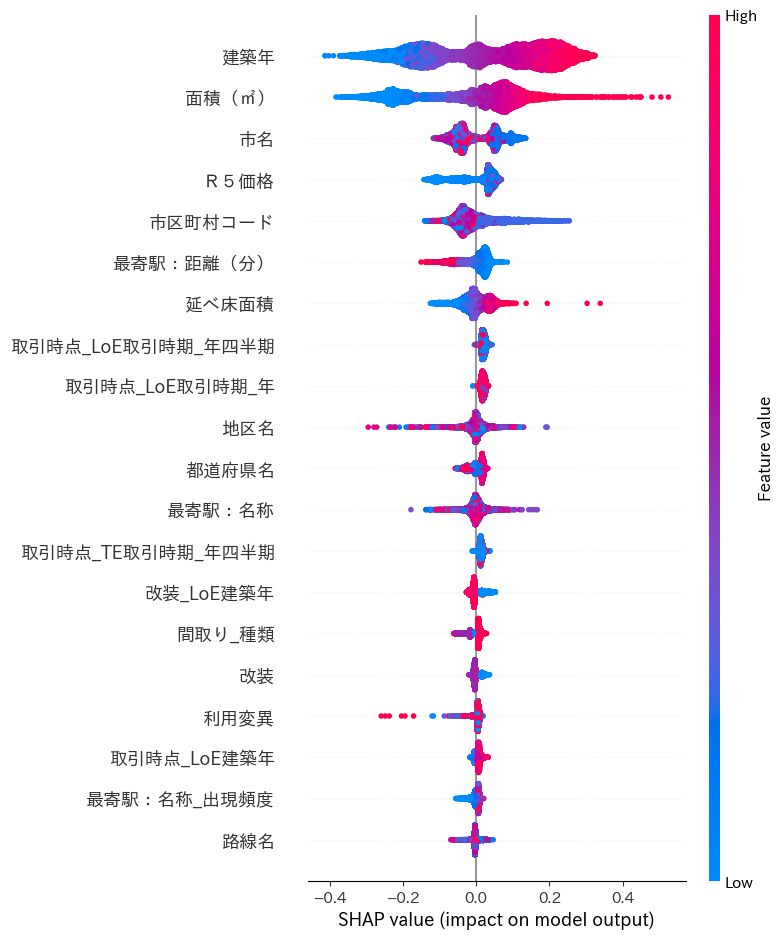

In [ ]:
shap.summary_plot(sv_test, test)

## 特徴量150を絞り込む

In [ ]:
#clf = model
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=test.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
sorted_idx = np.argsort(importance)
importance_handred = list(sorted_idx[:150].index)
display(importance_handred)

['建築年',
 '地区名',
 '面積（㎡）',
 '市区町村コード',
 '最寄駅：名称',
 '市名',
 'Ｒ５価格',
 '延べ床面積',
 '最寄駅：距離（分）',
 '都道府県名',
 '取引-建築',
 '間取り_種類',
 '取引時点_LoE取引時期_年',
 '路線名',
 '改装_LoE建築年',
 '取引時点_LoE建築年',
 '取引時点_LoE取引時期_年四半期',
 '取引時点_TE取引時期_年四半期',
 '最寄駅：名称_出現頻度',
 '区名',
 '利用変異',
 '取引の事情等_TE取引時期_四半期',
 '敷地面積',
 '改装',
 '改装_LoE取引-建築',
 '間取り_LoE面積（㎡）',
 '取引の事情等_不明',
 '運営会社',
 '地区名_TE最寄駅：距離（分）',
 '取引時点_LoE取引-建築',
 '取引時点_TE面積（㎡）',
 '間取り_TE取引時期_四半期',
 '取引時点_TE建築年',
 '都市計画',
 '駅別乗降客数_2018',
 '地区名_LoE最寄駅：距離（分）',
 '駅別乗降客数_2016',
 '最寄駅：名称_LoEＲ５価格',
 '取引時点_TE取引-建築',
 '間取り_数字',
 '今後の利用目的_LoE建築年',
 '今後の利用目的_LoE取引時期_四半期',
 '取引時点_TE建ぺい率（％）',
 '容積率（％）',
 '改装_LoE取引時期_四半期',
 '地区名_TE建築年',
 '取引の事情等_LoE建築年',
 '最寄駅：名称_TE容積率（％）',
 '取引時点_LoE建ぺい率（％）',
 '取引の事情等_TE建築年',
 '建物の構造_LoE建築年',
 '改装_LoE建ぺい率（％）',
 '間取り_LoE取引時期_四半期',
 '取引時点_出現頻度',
 '建物の構造_LoE取引-建築',
 '地区名_出現頻度',
 '最寄駅：名称_TE建ぺい率（％）',
 '取引時点_LoE取引時期_四半期',
 '間取り_LoE取引-建築',
 '間取り_LoE建ぺい率（％）',
 '取引時点_TE最寄駅：距離（分）',
 '今後の利用目的_LoE取引-建築',
 '間取り_LoE取引時期_年',
 '間取り_LoE建築年',
 '建物の構造_LoE取引時期_年',
 

In [ ]:
with open(path_start/"my_list_150.csv", "w") as f:
    for item in importance_handred:
        f.write(str(item) + "\n")
f.close()